# Abstract

Check queries with a small bbox. Do they really have max 7 features per location?

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from functools import partial
from itertools import cycle
from time import perf_counter
from tabulate import tabulate

from cirtorch.datasets.testdataset import configdataset
from cirtorch.utils.evaluate import compute_map_and_print
from asmk import io_helpers, ASMKMethod, functional, hamming
from examples.demo_how import build_ivf, query_ivf

In [2]:
def get_packed_residuals(vecs, centroids, binary=True):
    residuals = vecs - centroids
    
    if binary:
        return hamming.binarize_and_pack_2D(residuals)
    else:
        return functional.normalize_vec_l2(residuals)
    
def generate_hypotheses(coordx1, coordy1, scales1, coordx2, coordy2, scales2):
    # 1 -> 2
    m = np.tile(np.eye(3), [coordx1.size, 1, 1])
    s = scales2 / scales1
    
    m[:, 0, 2] = -1 * coordx1 * s + coordx2
    m[:, 1, 2] = -1 * coordy1 * s + coordy2
    m[:, 0, 0] = m[:, 1, 1] = s
    
    return m


def compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2):
    pts1 = np.vstack([coordx1, coordy1, np.ones_like(coordx1)])
    pts2 = np.vstack([coordx2, coordy2, np.ones_like(coordx2)])
    
    # [number of hypotheses, number of correspondences]
    return np.linalg.norm((hypotheses @ pts1) - pts2, axis=1)


def verify_single_model(errors, corrs, inlier_threshold=32):
    n = corrs.shape[0]
    mask = np.zeros([n], dtype=bool)
    taken = set()

    i = 0
    actual_y, best_index = None, None
    best_error = None
    while i < n:
        actual_y = corrs[i, 1]
        
        best_error = np.inf
        best_index = -1
        while i < n and actual_y == corrs[i, 1]:
            if errors[i] < best_error and corrs[i, 0] not in taken:
                best_error = errors[i]
                best_index = i
            i += 1
        
        if best_error <= inlier_threshold:
            mask[best_index] = True
            taken.add(corrs[best_index, 0])
    
    return mask


def verify_models(errors, corrs, inlier_threshold=32):
    return np.apply_along_axis(
        partial(verify_single_model, corrs=corrs, inlier_threshold=inlier_threshold),
        axis=1,
        arr=errors,
    )


def affine_local_optimization(A, coordx1, coordy1, coordx2, coordy2):
    size = coordx1.size
    
    if size < 3:
        return A
    
    weight = 2 * np.pi if size < 11 else 0
    r2h = 50.0  # half of squared circle radius is integrated over
    
    mx1, my1 = coordx1.mean(), coordy1.mean()
    mx2, my2 = coordx2.mean(), coordy2.mean()
    
    dx1, dy1 = (coordx1 - mx1), (coordy1 - my1)
    dx2, dy2 = (coordx2 - mx2), (coordy2 - my2)
    
    # Compute AtA, AtB1, AtB2
    AtA = [0.0, 0.0, 0.0]
    AtB1 = [0.0, 0.0]
    AtB2 = [0.0, 0.0]
    
    AtA[0] = ((1 + weight) * dx1 * dx1 + weight * r2h).sum()
    AtA[1] = ((1 + weight) * dx1 * dy1).sum()
    AtA[2] = ((1 + weight) * dy1 * dy1 + weight * r2h).sum()
    
    AtB1[0] = ((1 + weight) * dx1 * dx2 + weight * A[0, 0] * r2h).sum()
    AtB1[1] = ((1 + weight) * dy1 * dx2 + weight * A[0, 1] * r2h).sum()
    
    AtB2[0] = ((1 + weight) * dx1 * dy2 + weight * A[1, 0] * r2h).sum()
    AtB2[1] = ((1 + weight) * dy1 * dy2 + weight * A[1, 1] * r2h).sum()
    
    # Final affine transformation
    detAtA = AtA[0] * AtA[2] - AtA[1] * AtA[1]
    if detAtA == 0:
        raise ValueError('Determinant equals to zero.')
        
    norm = 1 / detAtA
    H0 = (AtA[2] * AtB1[0] - AtA[1] * AtB1[1]) * norm
    H1 = (-AtA[1] * AtB1[0] + AtA[0] * AtB1[1]) * norm
    H2 = mx2 - mx1 * H0 - my1 * H1
    H3 = (AtA[2] * AtB2[0] - AtA[1] * AtB2[1]) * norm
    H4 = (-AtA[1] * AtB2[0] + AtA[0] * AtB2[1]) * norm
    H5 = my2 - mx1 * H3 - my1 * H4
    
    H = np.array([
        [H0, H1, H2],
        [H3, H4, H5],
        [0, 0, 1],
    ])
    
    return H


def get_tentative_correspondencies(
    q_ids, db_ids, q_residual_packs, db_residual_packs, similarity_func, max_tc=1500, max_MxN=15,
):
    db_unique, db_counts = np.unique(db_ids, return_counts=True)
    q_unique, q_counts = np.unique(q_ids, return_counts=True)
    
    db_sorted = np.argsort(db_ids)
    q_sorted = np.argsort(q_ids)
    
    ret = []
    similarities = []
    # counts = []
    
    qr_i = 0  # query index
    db_i = 0  # database index
    s_qr_i = 0  # sorted query index
    s_db_i = 0  # sorted database index

    qr_len = q_unique.shape[0]
    db_len = db_unique.shape[0]
    s_qry_len = q_sorted.shape[0]
    s_rel_len = db_sorted.shape[0]
    
    while qr_i < qr_len and db_i < db_len:  # While there are any visual words remaining
        if q_unique[qr_i] == db_unique[db_i]:  # If we encountered the the same visual word
            # count = q_counts[qr_i] * db_counts[db_i]
            # if count <= max_MxN:
            if True:
            
                # Move the sorted indexes forward so we find the beginning of current visual word
                while s_qr_i < s_qry_len and q_ids[q_sorted[s_qr_i]] != q_unique[qr_i]:
                    s_qr_i += 1
                while s_db_i < s_rel_len and db_ids[db_sorted[s_db_i]] != db_unique[db_i]:
                    s_db_i += 1
                
                # Cross products of corresponding visual words
                count = q_counts[qr_i] * db_counts[db_i]
                cross_product_correspondences = np.zeros([count, 2])
                cross_product_similarities = np.zeros([count])
                cross_product_index = 0
                
                s_qr_i_start = s_qr_i
                while s_db_i < s_rel_len and db_ids[db_sorted[s_db_i]] == db_unique[db_i]:
                    s_qr_i = s_qr_i_start
                    while s_qr_i < s_qry_len and q_ids[q_sorted[s_qr_i]] == q_unique[qr_i]:
                        #ret.append([q_sorted[s_qr_i], db_sorted[s_db_i]])
                        #similarities.append(similarity_func(
                        #    q_residual_packs[q_sorted[s_qr_i]], db_residual_packs[db_sorted[s_db_i]]
                        #)[0])
                        #vw_ids.append(q_unique[qr_i])
                        
                        cross_product_correspondences[cross_product_index] = [q_sorted[s_qr_i], db_sorted[s_db_i]]
                        cross_product_similarities[cross_product_index] = similarity_func(
                            q_residual_packs[q_sorted[s_qr_i]], db_residual_packs[db_sorted[s_db_i]]
                        )[0]
                        cross_product_index += 1
                        
                        s_qr_i += 1
                    s_db_i += 1
                    
                if count <= max_MxN:
                    mask = np.ones_like(cross_product_similarities, dtype=bool)
                else:
                    threshold = -np.sort(-cross_product_similarities)[max_MxN]
                    mask = cross_product_similarities >= threshold
                    
                ret.extend(cross_product_correspondences[mask][:max_MxN])
                similarities.extend(cross_product_similarities[mask][:max_MxN])
                    
            qr_i += 1
            db_i += 1
        elif q_unique[qr_i] < db_unique[db_i]:
            qr_i += 1
        else:
            db_i += 1
            
    ret_np = np.array(ret, dtype=int, ndmin=2)
        
    # If there are way too many correspondences, crop the result
    similarities_np = np.array(similarities)
    if ret_np.shape[0] > max_tc:
        # counts_np = np.array(counts)
        # keys = np.argsort(counts, kind='stable')[:max_tc]
        # return ret_np[keys]
        
        # If we do not care about the order
        #
        # keys = np.argsort(-similarities_np, kind='stable')[:max_tc]
        # return ret_np[keys], similarities_np[keys]
        
        # If we want to preserve the order (same visual words in a row)
        
        threshold = -np.sort(-similarities_np)[max_tc]
        mask = similarities_np >= threshold
        
        return ret_np[mask][:max_tc], similarities_np[mask][:max_tc]

    return ret_np, similarities_np

In [3]:
PARAMETERS_PATH = 'eccv20_how_r50-_1000'
DATASET = 'roxford5k'
EVAL_FEATURES = 'how_r50-_1000'

# Global variables
package_root = Path('.').resolve().parent / 'asmk'
parameters_path = package_root / "examples" / ("params/%s.yml" % PARAMETERS_PATH)
params = io_helpers.load_params(parameters_path)

globals = {}
globals["root_path"] = (package_root / params['demo_how']['data_folder'])
exp_name = Path(parameters_path).name[:-len(".yml")]
globals["exp_path"] = (package_root / params['demo_how']['exp_folder']) / exp_name

# Setup logging
logger = io_helpers.init_logger(None)
logger.info("All variables and logger set up")

# Run demo
asmk = ASMKMethod.initialize_untrained(params)
logger.info("Created uninitialized ASMK")
asmk = asmk.train_codebook(cache_path=f"{globals['exp_path']}/codebook.pkl")
logger.info("Trained ASMK")

desc = io_helpers.load_pickle(f"{globals['root_path']}/features/{DATASET}_{EVAL_FEATURES}.pkl")
gnd = configdataset(DATASET, f"{globals['root_path']}/test/")

asmk_dataset = build_ivf(asmk, DATASET, desc, globals, logger)

ASMK INFO: All variables and logger set up
ASMK INFO: Created uninitialized ASMK
ASMK INFO: Trained ASMK
ASMK INFO: Loaded indexed ivf


In [4]:
scales = np.array([2.0, 1.414, 1.0, 0.707, 0.5, 0.353, 0.25])


def kernel_similarity(v1, v2):
    _, sim = asmk_dataset.kernel.similarity(v1, v2[np.newaxis], np.array([0]), alpha=1, similarity_threshold=-np.inf)
    return sim

In [5]:
t0 = perf_counter()

# Get centroid ids, then centroids and then residual packs
qvecs_centroid_ids = asmk_dataset.codebook.quantize(desc['qvecs'], multiple_assignment=1)[1].ravel()
# dbvecs_centroid_ids = asmk_dataset.codebook.quantize(desc['vecs'], multiple_assignment=1)[1].ravel()
dbvecs_centroid_ids = np.load('desc_vecs-quantized-dbvecs_centroid_ids.npy')

# ---
q_centroids = asmk_dataset.codebook.centroids[qvecs_centroid_ids]
db_centroids = asmk_dataset.codebook.centroids[dbvecs_centroid_ids]

q_residual_packs = get_packed_residuals(desc['qvecs'], q_centroids, binary=asmk_dataset.kernel.binary)
db_residual_packs = get_packed_residuals(desc['vecs'], db_centroids, binary=asmk_dataset.kernel.binary)

t1 = perf_counter()

(t1 - t0)

6.906054167018738

In [6]:
IMAGES_ROOT = Path('.').resolve().parent / 'oxbuild_images'

---

In [7]:
qi = 61
qi = 60

In [9]:
query_img = plt.imread(IMAGES_ROOT / f'{gnd["qimlist"][qi]}.jpg')
qbbx = gnd['gnd'][qi]['bbx']

In [11]:
if 1:
    # Query data
    ql = np.searchsorted(desc['qimids'], qi, 'left')
    qr = np.searchsorted(desc['qimids'], qi, 'right')
    
    q_vecs = desc['qvecs'][ql:qr]
    q_centroid_ids = qvecs_centroid_ids[ql:qr]
    q_coordx = desc['qcoordx'][ql:qr]
    q_coordy = desc['qcoordy'][ql:qr]
    q_scales = desc['qscales'][ql:qr]
    q_residuals = q_residual_packs[ql:qr]

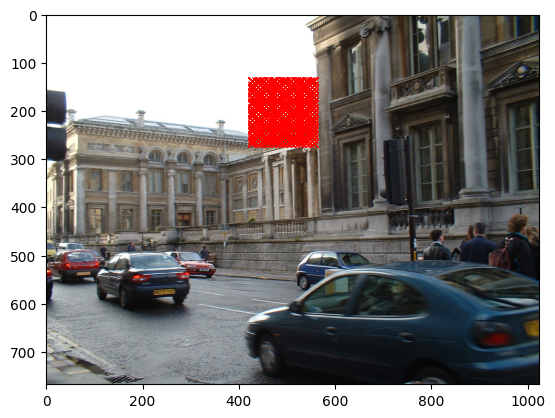

In [12]:
plt.imshow(query_img)
plt.plot(
    (qbbx[0] + (q_coordx * 16 / scales[q_scales])).astype(int),
    (qbbx[1] + (q_coordy * 16 / scales[q_scales])).astype(int),
    'rx',
)
plt.show()

In [20]:
x1, y1, x2, y2 = qbbx
indices_2d = np.vstack([q_coordx, q_coordy])
indices_1d = np.ravel_multi_index(indices_2d, (int(x2 - x1), int(y2 - y1)))
indices_1d.shape

(583,)

In [25]:
ul, uc = np.unique(indices_1d, return_counts=True)
ul[:5], uc[:5]

(array([0, 1, 2, 3, 4]), array([7, 7, 6, 5, 4]))

In [37]:
for label, count in zip(ul, uc):
    if count == 7:
        mask = (indices_1d == label)
        print(f'label #{label} \t', sorted(q_scales[mask]))

label #0 	 [0, 1, 2, 3, 4, 5, 6]
label #1 	 [0, 1, 2, 3, 4, 5, 6]
label #128 	 [0, 1, 2, 3, 4, 5, 6]
label #129 	 [0, 1, 2, 3, 4, 5, 6]


---

In [38]:
qi = 61

In [39]:
query_img = plt.imread(IMAGES_ROOT / f'{gnd["qimlist"][qi]}.jpg')
qbbx = gnd['gnd'][qi]['bbx']
if 1:
    # Query data
    ql = np.searchsorted(desc['qimids'], qi, 'left')
    qr = np.searchsorted(desc['qimids'], qi, 'right')
    
    q_vecs = desc['qvecs'][ql:qr]
    q_centroid_ids = qvecs_centroid_ids[ql:qr]
    q_coordx = desc['qcoordx'][ql:qr]
    q_coordy = desc['qcoordy'][ql:qr]
    q_scales = desc['qscales'][ql:qr]
    q_residuals = q_residual_packs[ql:qr]

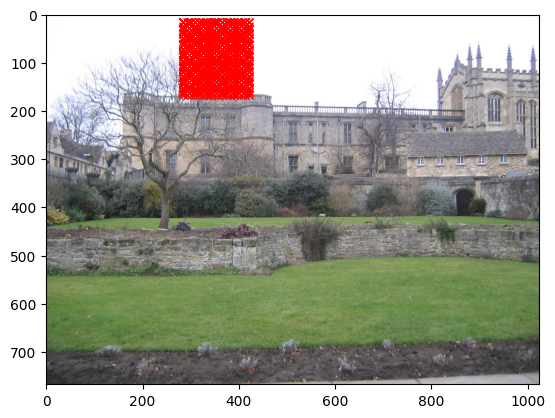

In [40]:
plt.imshow(query_img)
plt.plot(
    (qbbx[0] + (q_coordx * 16 / scales[q_scales])).astype(int),
    (qbbx[1] + (q_coordy * 16 / scales[q_scales])).astype(int),
    'rx',
)
plt.show()

In [41]:
x1, y1, x2, y2 = qbbx
indices_2d = np.vstack([q_coordx, q_coordy])
indices_1d = np.ravel_multi_index(indices_2d, (int(x2 - x1), int(y2 - y1)))
indices_1d.shape

(720,)

In [42]:
ul, uc = np.unique(indices_1d, return_counts=True)
ul[:5], uc[:5]

(array([0, 1, 2, 3, 4]), array([7, 7, 7, 6, 5]))

In [43]:
for label, count in zip(ul, uc):
    if count == 7:
        mask = (indices_1d == label)
        print(f'label #{label} \t', sorted(q_scales[mask]))

label #0 	 [0, 1, 2, 3, 4, 5, 6]
label #1 	 [0, 1, 2, 3, 4, 5, 6]
label #2 	 [0, 1, 2, 3, 4, 5, 6]
label #156 	 [0, 1, 2, 3, 4, 5, 6]
label #157 	 [0, 1, 2, 3, 4, 5, 6]
label #158 	 [0, 1, 2, 3, 4, 5, 6]
label #312 	 [0, 1, 2, 3, 4, 5, 6]
label #313 	 [0, 1, 2, 3, 4, 5, 6]
label #314 	 [0, 1, 2, 3, 4, 5, 6]
